<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Relaxation and Decoherence*_ 

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
Martin Sandberg, Hanhee Paik, Antonio Córcoles, Doug McClure, and Jay Gambetta

## Introduction

In an ideal world, quantum systems would be well-isolated from their environment, which prevents unwanted dynamics of the quantum information we encode in them. For example, suppose we prepared a qubit in the $|1\rangle$ state, but through interaction with the environment, the state is flipped to $|0\rangle$. That flip could affect the outcome of a quantum algorithm that's being run using that qubit, meaning the answers we get out of the quantum device would change. For this reason, we seek to isolate quantum computers from the surrounding environment.

However, perfect isolation is not possible: after all, we have to be able to control the quantum computer, which means coupling it to external systems to manipulate quantum information. This tradeoff is sometimes referred to as the "Tao of quantum computing". Because our controls introduce coupling between qubits and the environment, we expect some unwanted interactions can occur.

These unwanted interactions introduce _noise_ into the qubits, which affects their behavior. The rate of these interactions sets characteristic timescales over which information encoded in qubits can be reliably stored and manipulated. (If the interaction has a rate $\Gamma$, the characteristic timescale is $\sim 1/\Gamma$.) In this tutorial, we discuss two timescales that arise from energy relaxation and decoherence -- usually referred to as $T_{1}$ and $T_{2}$, respectively -- and show how they can be measured.

**Contents**

[Measuring $T_{1}$ time](#t1)

<a href='#t2star'>Measuring $T_{2}^{\star}$ time</a>

Code imports
==============

In [1]:
import qiskit as qk
import numpy as np
from scipy.optimize import curve_fit
from qiskit.tools.qcvv.fitters import exp_fit_fun, osc_fit_fun, plot_coherence
from qiskit.tools.monitor import job_monitor

In [ ]:
# Load saved IBMQ accounts
qk.IBMQ.load_accounts()

In [6]:
# backend and token settings
backend = qk.IBMQ.get_backend('ibmq_16_melbourne') # the device to run on
shots = 1024    # the number of shots in the experiment 

In [7]:
# This function is called in code below.
def pad_QId(circuit,N,qr):
    r'''A function for padding a circuit with identity gates.
    
    Args:
        circuit: The quantum circuit that the gates should be appended to
        N: The number of identity gates to add
        qr: The qubit register that the gates should be added to
    
    Returns:
        circuit: The original circuit object, but with N identity
                gates added to the qubit register qr
    '''
    for j in range(N):
        circuit.barrier(qr)
        circuit.iden(qr)
    return circuit    

<a id='t1'></a>

# Measuring $T_1$ time

**Theory**

The $T_{1}$ time is the characteristic timescale over which the state of a qubit damps toward the $|0\rangle$ state. Given an arbitrary initial single-qubit state $\rho(0)$, represented by a $2\times 2$ matrix as
$$\rho(0) = \begin{pmatrix}\rho_{00} & \rho_{01} \\ \rho_{01}^{\star} & \rho_{11}\end{pmatrix},$$
under amplitude damping noise, the state of the changes as
$$\rho(t) = \begin{pmatrix}\rho_{00} + (1-e^{-\Gamma_{1}t})\rho_{11} & e^{-\Gamma_{1}t/2}\rho_{01} \\ e^{-\Gamma_{1}t/2}\rho_{01}^{\star} & e^{-\Gamma_{1} t}\rho_{11}\end{pmatrix} \underset{t\rightarrow \infty}{\longrightarrow} |0\rangle\langle 0|.$$

Notice that amplitude damping noise also removes any coherences between $|0\rangle$ and $|1\rangle$ of the state (the off-diagonal elements.) The rate at which this _decoherence_ occurs is half that of $\Gamma_{1}$.

The time evolution of the state under amplitude damping noise can be derived as the continuous-time limit of an amplitude damping channel
$$\mathcal{E}[\rho] = M_{0} \rho M_{0}^{\dagger} + M_{1}\rho M_{1}^{\dagger},$$
where
$$M_{0} = \begin{pmatrix} 1 & 0 \\0& \sqrt{1-p}\end{pmatrix}~,~M_{1} = \begin{pmatrix} 0 & \sqrt{p} \\ 0 & 0 \end{pmatrix},$$
and the probability of decay $p$ is $\Gamma_{1}\Delta t$.

The decay rate $\Gamma_{1}$ sets a natural time scale for the decay process; namely, $\Gamma_{1}^{-1}$. This number is often called the $T_{1}$ time.

Notice that the probability of the qubit remaining in the $|1\rangle$ state is given by

$$P_{1}(t) = \mathrm{Tr}\left[|1\rangle\langle 1| \rho(t)\right] = e^{-\Gamma_{1} t}\rho_{11}.$$

If the qubit was prepared in the $|1\rangle$ state, then $P_{1}(t) =e^{-\Gamma_{1} t}$.

A simple way of estimating the $T_{1}$ time is to collect statistics about the decay curve for $P_{1}(t)$ when the qubit is initialized to $|1\rangle$. This can be done by choosing a variety of times $t_{1}, t_{2}, \cdots t_{N}$, and then running the following experiment many times:
* Prepare the qubit in $|1\rangle$.
* Wait a delay time $t_{j}$.
* Measure the qubit in the $|0\rangle, |1\rangle$ basis.

An estimate of $P_{1}(t_{j})$ is the number of times the qubit was observed to be in $|1\rangle$, divided by the total number of times the experiment was repeated. Given several estimated values of $P_{1}$ for a variety of $(t_{j})$, we can fit the resulting decay curve is fit to an exponential and extract an estimate of $\Gamma_{1}$, and hence, the $T_{1}$ time.

The IBM Q Experience does not currently support delays of arbitrary length, so for now, we just append a series of identity operations after the initial excitation pulse. Each identity operation has the same duration of a single-qubit gate and is followed by a -shorter- buffer time. These parameters are backend-dependent.

**Code**

The code blocks below walk through constructing the requisite experiments to estimate the $T_{1}$ time of a qubit, sending those experiments to an IBMQ backend, and then fitting the data the backend sends back.

In [27]:
# Select qubit whose T1 is to be measured
qubit = 1

# Creating registers
qr = qk.QuantumRegister(5)
cr = qk.ClassicalRegister(5)

# the delay times are all set in terms of single-qubit gates
# so we need to calculate the time from these parameters
pulse_length=100 # single-qubit gate time 
buffer_length=10 # spacing between pulses
unit = 'ns'

steps = 10
gates_per_step = 120
max_gates = (steps-1)*gates_per_step+1
tot_length = buffer_length+pulse_length
time_per_step = gates_per_step*tot_length
qc_dict = {}
for ii in range(steps):
    step_num = 'step_%s'%(str(ii))
    qc_dict.update({step_num:qk.QuantumCircuit(qr, cr)})
    qc_dict[step_num].x(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].barrier(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])

circuits=list(qc_dict.values())    

In [28]:
# run the program
t1_job = qk.execute(circuits, backend, shots=shots)
job_monitor(t1_job)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

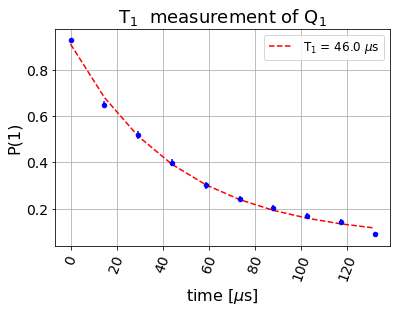

a: 0.84 ± 0.02
T1: 45.85 µs ± 3.27 µs
c: 0.07 ± 0.02


In [30]:
# arrange the data from the run

result_t1 = t1_job.result()
keys_0_1=list(result_t1.get_counts(qc_dict['step_0']).keys())# get the key of the excited state '00010' 
data=np.zeros(len(qc_dict.keys())) # numpy array for data
sigma_data = np.zeros(len(qc_dict.keys()))

# change unit from ns to microseconds
plot_factor=1
if unit.find('ns')>-1:
    plot_factor=1000
    punit='$\\mu$s'
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys()))/plot_factor # calculate the time steps in microseconds 

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(result_t1.get_counts(qc_dict[key])[keys_0_1[0]])/shots
    sigma_data[ii] = np.sqrt(data[ii]*(1-data[ii]))/np.sqrt(shots)

# fit the data to an exponential    
fitT1, fcov = curve_fit(exp_fit_fun, xvals, data, bounds=([-1,2,0], [1., 500, 1])) 
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT1, exp_fit_fun, punit, 'T$_1$ ', qubit)

print("a: " + str(round(fitT1[0],2)) + u" \u00B1 " + str(round(ferr[0],2)))
print("T1: " + str(round(fitT1[1],2))+ " µs" + u" \u00B1 " + str(round(ferr[1],2)) + ' µs')
print("c: " + str(round(fitT1[2],2)) + u" \u00B1 " + str(round(ferr[2],2)))

The last calibration of $T_1$ was measured to be

In [31]:
print(backend.properties().qubits[qubit][0].value, backend.properties().qubits[qubit][0].unit)

72.38826037862532 µs


<a id='t2star'></a>

# Measuring $T_2^*$ time

**Theory**

Amplitude damping noise affects the off-diagonal elements of the density matrix in addition to the on-diagonal elements. However, there are other noise processes that only affect the off-diagonal elements, while keeping the on-diagonal elements the same. These kinds of noise processes cause _decoherence_.

As a simple example of decoherence, consider the pure superposition state
$$|\psi(\theta)\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{i\theta}|1\rangle\right).$$
Expressed as a density matrix, this state is
$$\rho(\theta) = |\psi(\theta)\rangle \langle\psi(\theta)| = \frac{1}{2}\begin{pmatrix}1 & e^{-i\theta} \\ e^{i\theta} & 1\end{pmatrix}.$$

This state has _coherence_ between $|0\rangle$ and $|1\rangle$, which manifests itself in the non-zero off-diagonal terms. If the state had _decohered_, those off-diagonal terms would be zero:
$$\rho_{\mathrm{decohered}} =  \frac{1}{2}\begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}.$$
When the state has decohered, it can be written as a classical _mixture_:
$$\rho_{\mathrm{decohered}} = \frac{1}{2}\left(|0\rangle \langle 0| + |1\rangle \langle 1|\right).$$

One mechanism by which decoherence happens is _dephasing_. Under dephasing noise, the state of the qubit evolves as
$$\rho(t) = \begin{pmatrix}\rho_{00} & e^{-\Gamma_{2}t}\rho_{01} \\ e^{-\Gamma_{2}t}\rho_{01}^{\star} & \rho_{11}\end{pmatrix} \underset{t\rightarrow \infty}{\longrightarrow} \begin{pmatrix}\rho_{00} & 0\\ 0& \rho_{11}\end{pmatrix}.$$

The time evolution of $\rho$ under dephasing noise can be derived as the continuous-time limit of the following noise channel:
$$\mathcal{E}[\rho] = M_{0}\rho M_{0}^{\dagger} + M_{1} \rho M_{1}^{\dagger} + M_{2}\rho M_{2}^{\dagger},$$
where
$$M_{0} =\sqrt{1-p}I~,~M_{1} = \sqrt{p}\begin{pmatrix}1 &0 \\ 0 & 0 \end{pmatrix}~,~M_{2} = \sqrt{p}\begin{pmatrix}0 & 0 \\ 0 & 1\end{pmatrix}.$$


The rate of decay in the coherences can be measured by the following experiment:

* Prepare the qubit in the $|+\rangle$ state, which can be done by initializing the qubit to $|0\rangle$ and applying a Hadamard gate, $H$.
* Wait a delay time $t_{j}$.
* Measure the qubit in the $|\pm\rangle$ basis, which can be done by applying a Hadamard and then measuring in the computational basis.

If decoherence processes are present, then after a delay time $t_{j}$, the state of the qubit is

$$\rho(t_{j}) = \frac{1}{2}\begin{pmatrix}1 & e^{-\Gamma_{2}t_{j}} \\ e^{-\Gamma_{2}t_{j}} & 1\end{pmatrix}.$$

Measuring in the $|\pm\rangle$ basis, the probability of observing the outcome $|+\rangle$ is given by

$$P_{+}(t_{j}) = \mathrm{Tr}\left(|+\rangle \langle + | \rho(t_{j})\right) = \frac{1}{2}\left(1 + e^{-\Gamma_{2}t_{j}}\right).$$

Again, by estimating $P_{+}(t_{j})$ for a variety of $t_{j}$, we can then fit a decay curve to extract an estimate of $\Gamma_{2}$.

In the actual experiment, we change the phase of the pulse before the measurement in order to create oscillations in the observed dynamics of $P_{+}(t_{j})$. If we just did two Hadamard gates separated by a delay, we would observe a decay of characteristic time $T^*_2$, but with a strong dependence on any deviation of the calibrated qubit frequency from the actual one. By implementing the qubit pulses with different phases, we shift the frequency dependence into the oscillating feature of the dynamics, and can fit the decaying envelope for a more faithful measure of the coherence time.

<div class="alert alert-block alert-danger">

There is one subtle point of note. In the discussion of $T_{1}$ time above, we saw that amplitude damping noise also causes the off-diagonal elements to decay (at a rate $\Gamma_{1}/2$). Suppose a qubit was affected by only amplitude damping noise, and dephasing noise was absent. In this scenaro, _the rate of decay of coherences can be non-zero, even in the absense of dephasing noise_.

For this reason, it's important to recognize there are many noise processes contributing to the rate at which coherences decay. In this tutorial, we assume that the total rate of decoherence, $\Gamma$, can be decomposed into a sum of independent rates:

$$\Gamma = \Gamma_{T_{1}} + \Gamma_{2} + \Gamma_{\mathrm{other}}. $$

Phenomenologically, the rate $\Gamma_{\mathrm{other}}$ quantifies the rate of decoherence due to other noise processes in addition to pure amplitude damping and pure dephasing about the $Z$-axis. Note that because general noise can cause dephasing about the $Z$-axis -- in addition to doing other things to the qubit -- echo sequences are typically used to help mitigate the effects of those kind(s) of noise on $T_{2}^{\star}$. (Echo sequences are discussed below, in the sections $T_{2}$ echo  and CPMG measurement.)

If decoherence at a rate $\Gamma$ is taking place, then the state of the qubit changes as
$$\begin{equation}
\rho(t) = \begin{pmatrix}\rho_{00} & e^{-\Gamma t}\rho_{01} \\ e^{-\Gamma t}\rho_{01}^{\star} & 1-\rho_{00}\end{pmatrix}.
\end{equation}$$

The timescale associated with this decay rate is called $T_{2}$, and is given by $T_{2} = 1/\Gamma$.


$T_{2}$ relates to the other timescales introduced previously as
$$T_{2} = \left(\frac{2}{T_{1}} + \frac{1}{T_{2}} + \frac{1}{T_{\mathrm{other}}}\right)^{-1} = T_{2}^{\star}\left( 1 + \frac{2T_{2}^{\star}}{T_{1}} + \frac{T^{\star}_{2}}{T_{\mathrm{other}}}\right)^{-1} \leq T_{2}^{\star},$$
where we've defined $T_{\mathrm{other}}  = 1 /\Gamma_{\mathrm{other}}$.

</div> 

In [32]:
# Select qubit on which to measure T2*
qubit = 1

# Creating registers
qr = qk.QuantumRegister(5)
cr = qk.ClassicalRegister(5)

steps = 35
gates_per_step = 20
max_gates = (steps-1)*gates_per_step+2

num_osc = 5
tot_length = buffer_length+pulse_length
time_per_step = gates_per_step*tot_length
qc_dict = {}
for ii in range(steps):
    step_num = 'step_%s'%(str(ii))
    qc_dict.update({step_num:qk.QuantumCircuit(qr, cr)})
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].u1(2*np.pi*num_osc*ii/(steps-1),qr[qubit])
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num].barrier(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])
circuits = list(qc_dict.values())    


In [33]:
# run the program
t2star_job = qk.execute(circuits, backend, shots=shots)
job_monitor(t2star_job)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

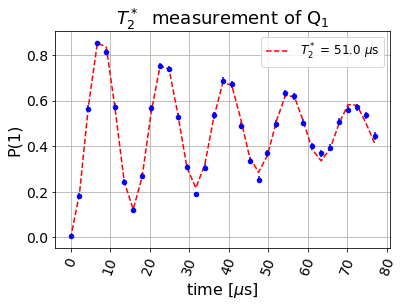

a: 0.48 ± 0.01
T2*: 51.14 µs ± 2.18 µs
f: 63.006kHz ± 140.469kHz
phi: 3.15 ± 0.03
c: 0.47 ± 0.0


In [34]:
# arrange the data from the run

result_t2star = t2star_job.result()
keys_0_1 = list(result_t2star.get_counts(qc_dict['step_0']).keys())# get the key of the excited state '00010' 

# change unit from ns to microseconds
plot_factor = 1
if unit.find('ns') > -1:
    plot_factor = 1000
    punit = '$\\mu$s'
xvals = time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys()))/plot_factor # calculate the time steps 


data = np.zeros(len(qc_dict.keys())) # numpy array for data
sigma_data = np.zeros(len(qc_dict.keys()))

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii] = float(result_t2star.get_counts(qc_dict[key])[keys_0_1[0]])/shots
    sigma_data[ii] = np.sqrt(data[ii]*(1-data[ii]))/np.sqrt(shots)
    
fitT2s, fcov = curve_fit(osc_fit_fun, xvals, data, p0=[0.5, 100, 1/10, np.pi, 0],
                         bounds=([0.3,0,0,0,0], [0.5, 200, 1/2,2*np.pi,1]))
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT2s, osc_fit_fun, punit, '$T_2^*$ ', qubit)

print("a: " + str(round(fitT2s[0],2)) + u" \u00B1 " + str(round(ferr[0],2)))
print("T2*: " + str(round(fitT2s[1],2))+ " µs"+ u" \u00B1 " + str(round(ferr[1],2)) + ' µs')
print("f: " + str(round(10**3*fitT2s[2],3)) + 'kHz' + u" \u00B1 " + str(round(10**6*ferr[2],3)) + 'kHz')
print("phi: " + str(round(fitT2s[3],2)) + u" \u00B1 " + str(round(ferr[3],2)))
print("c: " + str(round(fitT2s[4],2)) + u" \u00B1 " + str(round(ferr[4],2)))

<a id='t2echo'></a>

# Measurement of $T_2$ Echo

We have referred to the previous experiment's characteristic time as $T^*_2$ and not $T_2$ by analogy to nuclear magnetic resonance (NMR). Indeed, one can isolate different frequency components to the decoherence process by devising increasingly elaborated pulse sequences. To illustrate the analogy with NMR, one can think about an ensemble of nuclear spins precessing in an external DC magnetic field. Due to field inhomogeneities, each spin might precess with a slightly different Larmor frequency. This certainly will affect the observed coherence time of the ensemble. However, it is possible to echo away this low-frequency decoherence process by applying a pi-pulse to the system halfway through the delay. The effect of this pi-pulse is to reverse the direction of the precession of each individual spin due to field inhomogeneities. Thus, the spins that had precessed more now start precessing in the opposite direction faster than the spins that had precessed less, and after an equal delay, all the spins in the system recover the initial coherence, except for other, higher-frequency, decoherence mechanisms.

Here, we are measuring only a single qubit rather than an ensemble of spins. Consequently coherence measurements require averaging an ensemble of measurements in order to eliminate projection noise, and run-to-run fluctuations in the qubit's frequency which will similarly manifest themselves as decoherence if they are not canceled out. By running this $T_2$ echo sequence, we can therefore remove low-frequency components of the decoherence.

In [36]:
# Select qubit to measure T2 echo on
qubit = 1

# Creating registers
qr = qk.QuantumRegister(5)
cr = qk.ClassicalRegister(5)

steps = 18
gates_per_step = 28
tot_length = buffer_length+pulse_length
max_gates = (steps-1)*2*gates_per_step+3
time_per_step = (2*gates_per_step)*tot_length
qc_dict = {}
for ii in range(steps):
    step_num = 'step_%s'%(str(ii))
    qc_dict.update({step_num:qk.QuantumCircuit(qr, cr)})
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].x(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num].barrier(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])
circuits = list(qc_dict.values())    


In [37]:
# run the program
t2echo_job = qk.execute(circuits, backend, shots=shots)
job_monitor(t2echo_job)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

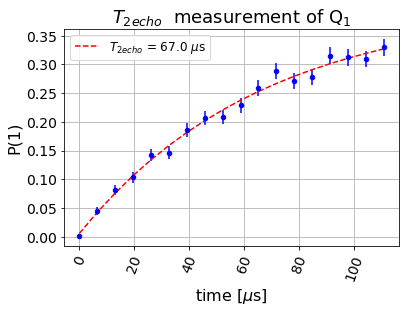

a: -0.4 ± 0.02
T2: 66.96 µs ± 8.11 µs
c: 0.4 ± 0.02


In [39]:
# arrange the data from the run

result_t2echo = t2echo_job.result()
keys_0_1 = list(result_t2echo.get_counts(qc_dict['step_0']).keys())# get the key of the excited state '00010' 


# change unit from ns to microseconds
plot_factor=1
if unit.find('ns')>-1:
    plot_factor=1000
    punit='$\\mu$s'
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys()))/plot_factor # calculate the time steps 


data=np.zeros(len(qc_dict.keys())) # numpy array for data
sigma_data = np.zeros(len(qc_dict.keys()))


for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(result_t2echo.get_counts(qc_dict[key])[keys_0_1[0]])/shots
    sigma_data[ii] = np.sqrt(data[ii]*(1-data[ii]))/np.sqrt(shots)
    
fitT2e, fcov = curve_fit(exp_fit_fun, xvals, data, bounds=([-1,10,0], [1, 150, 1])) 
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT2e, exp_fit_fun, punit, '$T_{2echo}$ ', qubit)

print("a: " + str(round(fitT2e[0],2)) + u" \u00B1 " + str(round(ferr[0],2)))
print("T2: " + str(round(fitT2e[1],2))+ ' µs' + u" \u00B1 " + str(round(ferr[1],2)) + ' µs')
print("c: " + str(round(fitT2e[2],2)) + u" \u00B1 " + str(round(ferr[2],2)))

The last calibration of $T_2$ was measured to be

In [40]:
print(backend.properties().qubits[qubit][1].value, backend.properties().qubits[qubit][1].unit)

111.62868245151734 µs


<a id='cpmg'></a>

## CPMG measurement
 
As explained above, the echo sequence removes low-frequency decoherence mechanisms. This noise-filtering procedure can be extended with increased number of pi-pulses within the delay. In the following experiment, we implement an echo experiment with seven pi-pulses during the delay between the initial and final pulses. This kind of echo with several pi-pulses is referred to as a CPMG experiment, after Carr, Purcell, Meiboom, and Gill.  

In [41]:
# Select qubit for CPMG measurement of T2
qubit = 1

# Creating registers
qr = qk.QuantumRegister(5)
cr = qk.ClassicalRegister(5)

steps = 10
gates_per_step = 18
num_echo = 5 # has to be odd number to end up in excited state at the end
tot_length = buffer_length+pulse_length
time_per_step = ((num_echo+1)*gates_per_step+num_echo)*tot_length
max_gates = num_echo*(steps-1)*gates_per_step+num_echo+2
qc_dict = {}
for ii in range(steps):
    step_num='step_%s'%(str(ii))
    qc_dict.update({step_num:qk.QuantumCircuit(qr, cr)})
    qc_dict[step_num].h(qr[qubit])
    for iii in range(num_echo):
        qc_dict[step_num]=pad_QId(qc_dict[step_num], gates_per_step*ii, qr[qubit])
        qc_dict[step_num].x(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num], gates_per_step*ii, qr[qubit])
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num].barrier(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])
circuits=list(qc_dict.values())


In [42]:
# run the program
t2cpmg_job = qk.execute(circuits, backend, shots=shots)
job_monitor(t2cpmg_job)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

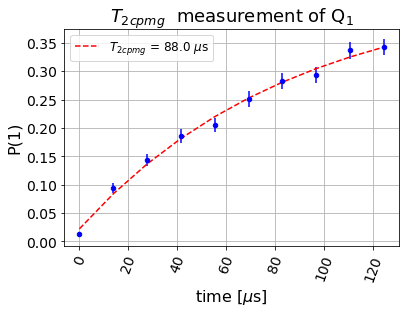

a: -0.42 ± 0.04
T2: 87.67 µs ± 15.38 µs
c: 0.44 ± 0.04


In [43]:
# arrange the data from the run

result_t2cpmg = t2cpmg_job.result()
keys_0_1 = list(result_t2cpmg.get_counts(qc_dict['step_0']).keys())# get the key of the excited state '00001' 


# change unit from ns to microseconds
plot_factor = 1
if unit.find('ns') > -1:
    plot_factor = 1000
    punit = '$\\mu$s'
xvals = time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys()))/plot_factor # calculate the time steps 


data = np.zeros(len(qc_dict.keys())) # numpy array for data
sigma_data = np.zeros(len(qc_dict.keys()))

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii] = float(result_t2cpmg.get_counts(qc_dict[key])[keys_0_1[0]])/shots
    sigma_data[ii] = np.sqrt(data[ii]*(1-data[ii]))/np.sqrt(shots)
    
fitT2cpmg, fcov = curve_fit(exp_fit_fun, xvals, data, bounds=([-1,10,0], [1, 150, 1])) 
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT2cpmg, exp_fit_fun, punit, '$T_{2cpmg}$ ', qubit)

print("a: " + str(round(fitT2cpmg[0],2)) + u" \u00B1 " + str(round(ferr[0],2)))
print("T2: " + str(round(fitT2cpmg[1],2))+ ' µs' + u" \u00B1 " + str(round(ferr[1],2)) + ' µs')
print("c: " + str(round(fitT2cpmg[2],2)) + u" \u00B1 " + str(round(ferr[2],2)))